# NYC Taxi Fare Prediction

## EDA, Visualization and Modeling



### By : Gurteg, Lovleen, Ritu , Subham

#### INTRODUCTION: 

Nowadays with the increasing demand for cabs in urban cities, it is becoming difficult to estimate the factors contributing to the dynamic fare price change. So to overcome this challenge we came up with an objective to build a comprehensive trip fare prediction model. It will analyze and predict the dynamic pricing of taxi services in New York City based on location, seasonal and temporal features. 



#### Source:
https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/data



###### We have taken 0.2 milions rows out of the Kaggle source containing 5 million rows, as we were facing computation issues while fetching 5 million rows


### PROPOSED ANALYSIS & METHODOLOGY:



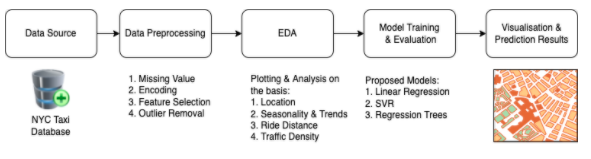

In [307]:

#Importing Libraries

import warnings
warnings.filterwarnings("ignore")
import os as os
os.getcwd() 
!pip install geopy
# initialize Nominatim API 
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="geoapiExercises")
!pip install pandasql
from pandasql import sqldf
import pandas as pd
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix,accuracy_score
!pip install folium
import folium
from branca.element import Figure
from matplotlib import pyplot as plt
import seaborn as sns
import numpy
from numpy import arange
from matplotlib import pyplot
from pandas import read_csv
from pandas import set_option
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Database Setup and Normalization




### Step 1 Create SQLite Database

### Step 2 Create and normalize a table named TaxiData 

### Step 3 Parse the data from a csv file

### Step 4 Insert the parsed data into the TaxiData Table

In [308]:
# Functions for Database Set up and Normalization

from IPython.display import display, HTML
import pandas as pd
import sqlite3
from sqlite3 import Error

#function to create a connection to the database
def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn

# function to create an SQLite table
def create_table(conn, create_table_sql, drop_table_name=None):
    
    if drop_table_name: # You can optionally pass drop_table_name to drop the table. 
        try:
            c = conn.cursor()
            c.execute("""DROP TABLE IF EXISTS %s""" % (drop_table_name))
        except Error as e:
            print(e)
    
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
# function to execute a sql statement        
def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows


In [309]:

#function to create the final normalized table with the values

def create_taxi_table(database_filename):
    # Inputs: Name of the data and normalized database filename
    
    
    # parsing a csv file and storing the results
    with open('/data/home/gurri/Python-Final-Project/Notebooks/data/taxi_fare_data.csv', 'r') as f:
        results = []
        for line in f:
            
            words = line.strip('\n').split(',')
            
            results.append(words)
    
    # creating the table
    create_table_taxi = """CREATE TABLE IF NOT EXISTS [TaxiData] (
        [trip_id] integer not null Primary Key autoincrement,
        [timestamp] Text  ,
        [fare_amount] float,
        [pickup_datetime] Text ,
        [pickup_longitude] float,
        [pickup_latitude] float ,
        [dropoff_longitude] float ,
        [dropoff_latitude] float ,
        [passenger_count] Integer 
        
        );
        """
    #calling connection
    conn = create_connection(database_filename)
    create_table(conn, create_table_taxi,drop_table_name='TaxiData')

    # insert values into the table
    with conn:        
            cursor = conn.cursor() 
            cursor.executemany("""INSERT INTO TaxiData('timestamp',
             'fare_amount',
             'pickup_datetime',
             'pickup_longitude',
             'pickup_latitude',
             'dropoff_longitude',
             'dropoff_latitude',
             'passenger_count')
            VALUES (?,?,?,?,?,?,?,?)""",results[1:])

    conn.commit()

In [310]:
#Calling functions to create the final Normalized TaxiData table in the Database - finalproject.db
database_filename = 'finalproject.db'
create_taxi_table(database_filename)
conn = create_connection(database_filename)
cur = conn.cursor()
df = pd.read_sql_query("""SELECT * FROM TaxiData""", conn)


## Database Schema

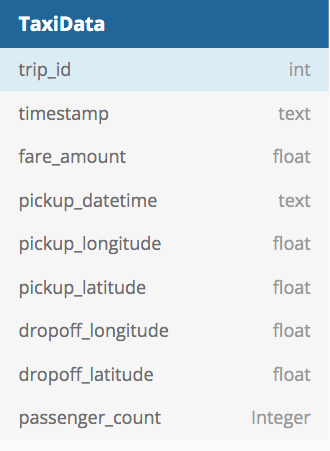


#### Schema

##### trip_id - Primary Key indicatiing Unique Trip Id for each ride
##### timestamp - Timestamp when the ride started
##### fare_amount= the fare of the ride
##### pickup_datetime - timestamp value indicating when the taxi ride started in UTC
##### pickup_longitude - float for longitude coordinate of where the taxi ride started.
##### pickup_latitude - float for latitude coordinate of where the taxi ride started.
##### dropoff_longitude - float for longitude coordinate of where the taxi ride ended.
##### dropoff_latitude - float for latitude coordinate of where the taxi ride ended.
##### passenger_count - integer

In [311]:
#First 5 rows of our table
df.head()

,trip_id,timestamp,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,1,2015-06-30 23:59:54.000000300,8.0,2015-06-30 23:59:54 UTC,-73.968117,40.751141,-73.980461,40.732216,1
1,2,2015-06-30 23:59:52.000000100,9.5,2015-06-30 23:59:52 UTC,-73.944077,40.711658,-73.982857,40.719799,1
2,3,2015-06-30 23:59:48.000000300,33.5,2015-06-30 23:59:48 UTC,-73.970360,40.783756,-73.870560,40.709118,1
3,4,2015-06-30 23:59:48.000000200,6.0,2015-06-30 23:59:48 UTC,-73.978867,40.750820,-73.989326,40.740780,2
4,5,2015-06-30 23:59:46.000000100,24.5,2015-06-30 23:59:46 UTC,-73.987198,40.739059,-73.962769,40.672539,2


# EDA and Feature Engineering

### Step 1 Check for null values and duplicates

1. There were no Nulls or Duplicates in the data







### Step 2 Check for Outliers 

2. Outliers were removed from the data.Below are the Ranges after removing Outlier values;
    fare_amount: 1 to 500
    longitudes: -75 to -72
    latitudes: 40 to 43
    passenger_count: 1 to 6
    





### Step 3 Create Time Features from Timestamp - Day of week,Hour of the day etc., calculate trip distance based on pick and drop coordinates

3. Created - Time Features -Day of the week, Hour of the day
4. Created Trip Distance Feature based on pick up and drop coordinates

In [312]:
# information about our data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   trip_id            200000 non-null  int64  
 1   timestamp          200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  200000 non-null  float64
 7   dropoff_latitude   200000 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [313]:
#checking null values
df.isnull().sum()


trip_id              0
timestamp            0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [314]:
# check duplicate values
df.duplicated().sum()



0

In [315]:
#Descriptive Statistics of data
df.describe()

,trip_id,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,100000.500000,13.468479,-72.895664,40.156331,-72.950900,40.189314,1.689470
std,57735.171256,12.262425,8.873970,4.886445,8.652198,4.832543,1.336832
min,1.000000,-100.000000,-171.797348,0.000000,-171.797348,0.000000,0.000000
25%,50000.750000,6.500000,-73.992012,40.735687,-73.991348,40.734523,1.000000
50%,100000.500000,9.500000,-73.981812,40.752670,-73.979897,40.753468,1.000000
75%,150000.250000,15.000000,-73.967062,40.767239,-73.962784,40.768250,2.000000
max,200000.000000,900.000000,0.000000,69.702576,0.000000,405.049988,9.000000


In [316]:
# Checking Negative Fare Amounts
df[df['fare_amount']<0].head()


,trip_id,timestamp,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
20361,20362,2015-06-29 22:02:53.000000700,-2.5,2015-06-29 22:02:53 UTC,0.000000,0.000000,0.000000,0.000000,1
24553,24554,2015-06-29 18:09:59.000000400,-2.5,2015-06-29 18:09:59 UTC,-73.956184,40.781513,-73.955559,40.781132,1
27499,27500,2015-06-29 14:40:03.000000400,-4.5,2015-06-29 14:40:03 UTC,-73.954895,40.782585,-73.953712,40.778721,1
28575,28576,2015-06-29 13:33:58.000000200,-2.5,2015-06-29 13:33:58 UTC,-73.993469,40.746857,-73.993919,40.746155,1
38443,38444,2015-06-28 21:56:55.000000300,-5.5,2015-06-28 21:56:55 UTC,-74.006744,40.744240,-74.007042,40.743736,1


In [317]:
# Checking Fare Amounts >500
df[df['fare_amount']>500]


,trip_id,timestamp,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
18212,18213,2015-06-30 00:46:07.000000400,900.0,2015-06-30 00:46:07 UTC,-73.943039,40.850475,-73.935555,40.859848,1


In [318]:
#Outlier removal

#Accepted Values of Features
    # fare_amount: 1 to 500
    # longitudes: -75 to -72
    # latitudes: 40 to 43
    # passenger_count: 1 to 6


#function to remove any outliers
def remove_outliers(df):
    return df[(df['fare_amount'] >= 1.) & 
              (df['fare_amount'] <= 500.) &
              (df['pickup_longitude'] >= -75) & 
              (df['pickup_longitude'] <= -72) & 
              (df['dropoff_longitude'] >= -75) & 
              (df['dropoff_longitude'] <= -72) & 
              (df['pickup_latitude'] >= 40) & 
              (df['pickup_latitude'] <= 43) & 
              (df['dropoff_latitude'] >=40) & 
              (df['dropoff_latitude'] <= 43) & 
              (df['passenger_count'] >= 1) & 
              (df['passenger_count'] <= 6)]

In [319]:
df=remove_outliers(df)

In [320]:
# df after outlier removal
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196611 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   trip_id            196611 non-null  int64  
 1   timestamp          196611 non-null  object 
 2   fare_amount        196611 non-null  float64
 3   pickup_datetime    196611 non-null  object 
 4   pickup_longitude   196611 non-null  float64
 5   pickup_latitude    196611 non-null  float64
 6   dropoff_longitude  196611 non-null  float64
 7   dropoff_latitude   196611 non-null  float64
 8   passenger_count    196611 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 15.0+ MB


In [321]:
# calculate Trip distances in miles for each ride

# function to find distance of each ride based on pickup and drop locations using haversine formula
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km/0.621


In [322]:
# function to add trip distance column to our df
def add_trip_distance(df):
    df['trip_distance'] = haversine_np(df['pickup_longitude'], df['pickup_latitude'], df['dropoff_longitude'], df['dropoff_latitude'])

In [323]:
#adding trip distance column to our df
add_trip_distance(df)

In [324]:
# df after adding trip distance
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196611 entries, 0 to 199999
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   trip_id            196611 non-null  int64  
 1   timestamp          196611 non-null  object 
 2   fare_amount        196611 non-null  float64
 3   pickup_datetime    196611 non-null  object 
 4   pickup_longitude   196611 non-null  float64
 5   pickup_latitude    196611 non-null  float64
 6   dropoff_longitude  196611 non-null  float64
 7   dropoff_latitude   196611 non-null  float64
 8   passenger_count    196611 non-null  int64  
 9   trip_distance      196611 non-null  float64
dtypes: float64(6), int64(2), object(2)
memory usage: 16.5+ MB


In [325]:
# Converting timestamp columns to timestamp datatype
df['timestamp']=pd.to_datetime(df['timestamp'])

In [326]:
# function to extract pickup_datetime features

def extract_time_features(df):
    timezone_name = 'America/New_York'
    time_column = "pickup_datetime"
    df.index = pd.to_datetime(df[time_column])
    df.index = df.index.tz_convert(timezone_name)
    df["dow"] = df.index.weekday
    df["hour"] = df.index.hour
    df["month"] = df.index.month
    df["year"] = df.index.year
    return df.reset_index(drop=True)


In [327]:
# df after extracting day of week,hour , month,year
df = extract_time_features(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196611 entries, 0 to 196610
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   trip_id            196611 non-null  int64         
 1   timestamp          196611 non-null  datetime64[ns]
 2   fare_amount        196611 non-null  float64       
 3   pickup_datetime    196611 non-null  object        
 4   pickup_longitude   196611 non-null  float64       
 5   pickup_latitude    196611 non-null  float64       
 6   dropoff_longitude  196611 non-null  float64       
 7   dropoff_latitude   196611 non-null  float64       
 8   passenger_count    196611 non-null  int64         
 9   trip_distance      196611 non-null  float64       
 10  dow                196611 non-null  int64         
 11  hour               196611 non-null  int64         
 12  month              196611 non-null  int64         
 13  year               196611 non-null  int64   

In [328]:
df.describe()

,trip_id,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,dow,hour,month,year
count,196611.000000,196611.000000,196611.000000,196611.000000,196611.000000,196611.000000,196611.000000,196611.000000,196611.000000,196611.000000,196611.0,196611.0
mean,99970.874107,13.447374,-73.973692,40.750317,-73.973604,40.751230,1.692133,5.672918,2.834572,12.143278,6.0,2015.0
std,57762.677192,11.868408,0.039233,0.028030,0.036865,0.032025,1.339673,6.384694,2.140182,5.872546,0.0,0.0
min,1.000000,1.000000,-74.780418,40.498440,-74.780418,40.350159,1.000000,0.000000,0.000000,0.000000,6.0,2015.0
25%,49926.500000,6.500000,-73.992172,40.737011,-73.991463,40.735764,1.000000,2.049102,1.000000,7.000000,6.0,2015.0
50%,99940.000000,9.500000,-73.982048,40.753231,-73.980232,40.753963,1.000000,3.503817,3.000000,13.000000,6.0,2015.0
75%,150019.500000,15.000000,-73.968033,40.767538,-73.963936,40.768440,2.000000,6.506431,5.000000,17.000000,6.0,2015.0
max,200000.000000,475.000000,-73.135628,41.095119,-73.135628,41.236969,6.000000,129.747472,6.000000,23.000000,6.0,2015.0


#### We see that all our ride data belongs to June 2015

### Step4. Create Visualizations and Analyse the trends

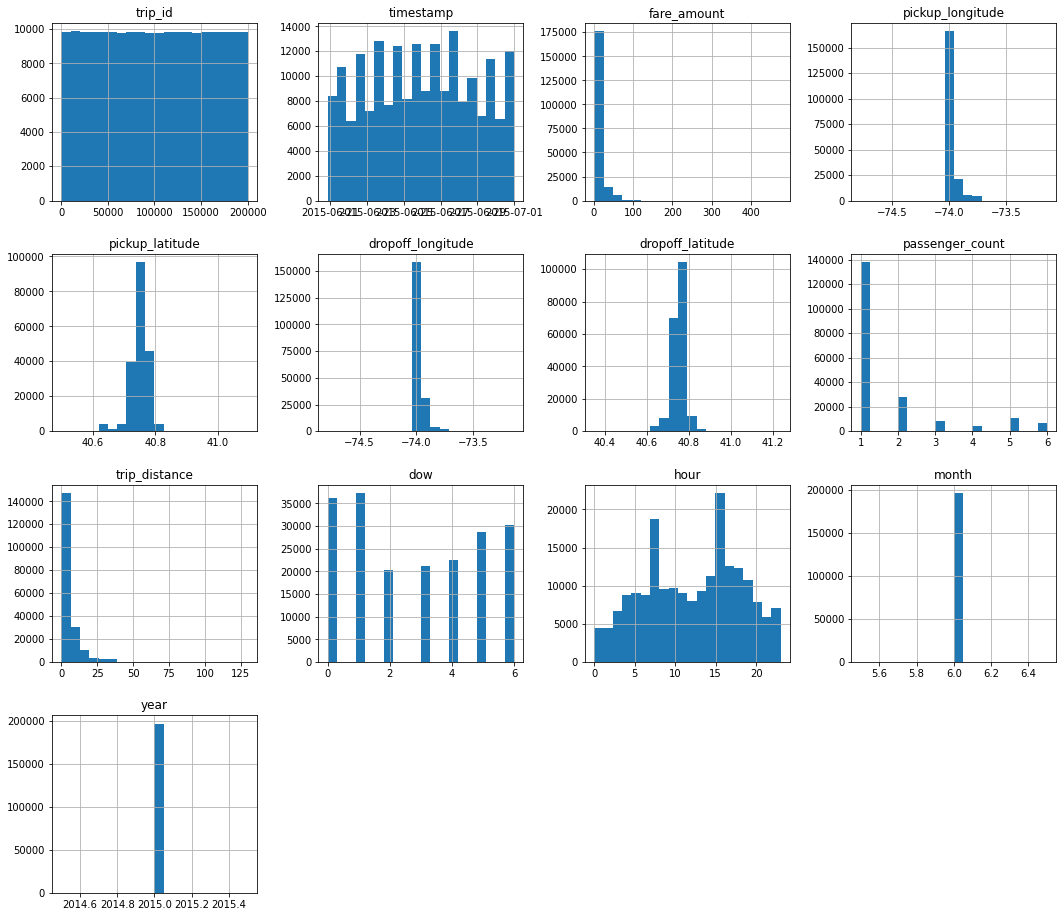

In [329]:
# Histograms depicting the features
df.hist(figsize=(18,16), bins=20);


#### Day wise Ride Distribution

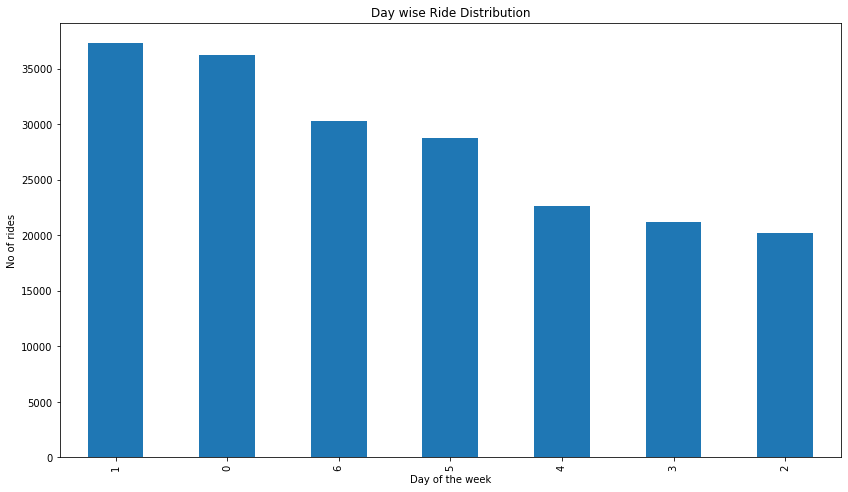

In [330]:
##Day wise Rides Distribution

ax = df['dow'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Day wise Ride Distribution")
ax.set_xlabel("Day of the week")
ax.set_ylabel("No of rides")
plt.show()


##### 0- Sunday, 1- Monday, 2- Tuesday , 3- Wednesday, 4- Thursday, 5- Friday, 6- Saturday
##### Sunday and Monday are busiest days of the week

#### Trip Distance vs Ride Fare

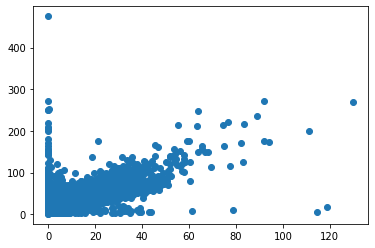

In [331]:
#Scatter Plot depicting relation between  Trip Distance and Fare

x=df['trip_distance']
y=df['fare_amount']
plt.scatter(x, y)
plt.show()

##### Fare prices are positively correlated with Trip Distance, as expected

In [332]:
# creating df to get avg no of rides for each day and times of the day
dow_hour_rides=sqldf("""select distinct case when dow =0 then 'Day0 Sunday'
        when dow =1 then 'Day1 Monday'
        when dow =2 then 'Day2 Tuesday'
        when dow =3 then 'Day3 Wednesday'
        when dow =4 then 'Day4 Thursday'
        when dow =5 then 'Day5 Friday'
        when dow =6 then 'Day6 Saturday'
        end as dow
        ,
    avg(case when hour = 0  then round(trip_id,0) end) as '12am',
    avg(case when hour = 1  then round(trip_id,1) end) as '1am',
    avg(case when hour = 2  then round(trip_id,2) end) as '2am',
    avg(case when hour = 3  then round(trip_id,3) end) as  '3am',
    avg(case when hour = 4  then round(trip_id,4) end) as   '4am',
    avg(case when hour = 5  then round(trip_id,5) end) as   '5am',
    avg(case when hour = 6  then round(trip_id,6) end) as   '6am',
    avg(case when hour = 7  then round(trip_id,7) end) as   '7am',
    avg(case when hour = 8  then round(trip_id,8) end) as   '8am',
    avg(case when hour = 9  then round(trip_id,9) end) as   '9am',
    avg(case when hour = 10  then round(trip_id,10) end)   as '10am',
    avg(case when hour = 11 then round(trip_id,11) end) as '11am',
    avg(case when hour = 12  then round(trip_id,12) end)   as '12 noon',
    avg(case when hour = 13 then round(trip_id,13) end)   as '1pm',
    avg(case when hour = 14 then round(trip_id,14) end)   as '2pm',
    avg(case when hour = 15 then round(trip_id,15) end)   as '3pm',
    avg(case when hour = 16 then round(trip_id,16) end)   as '4pm',
    avg(case when hour = 17 then round(trip_id,17) end)   as '5pm',
    avg(case when hour = 18 then round(trip_id,18) end)   as '6pm',
    avg(case when hour = 19 then round(trip_id,19) end)   as '7pm',
    avg(case when hour = 20 then round(trip_id,20) end)   as '8pm',
    avg(case when hour = 21 then round(trip_id,21) end)   as '9pm',
    avg(case when hour = 22 then round(trip_id,22) end)   as '10pm',
    avg(case when hour = 23 then round(trip_id,23) end)   as '11pm'
    
    from df group by 1""")
dow_hour_rides

,dow,12am,1am,2am,3am,4am,5am,6am,7am,8am,...,2pm,3pm,4pm,5pm,6pm,7pm,8pm,9pm,10pm,11pm
0,Day0 Sunday,100493.916955,94534.158940,102699.183349,108827.153303,105859.369565,101264.011230,99419.652523,102720.650588,100692.358684,...,95296.990888,96374.075594,93855.728522,94242.177434,93675.431720,90155.635410,90433.547573,87782.803571,85173.506667,95508.441048
1,Day1 Monday,86073.577519,84183.071809,88234.573034,90200.736185,86967.174896,90514.789981,88928.713294,90544.323372,83936.804938,...,83487.134656,74302.485573,73311.792523,72470.605465,72578.645669,68690.137190,138680.038526,138181.762533,137874.500000,137676.981707
2,Day2 Tuesday,137514.940000,137336.281407,136951.579892,136232.942130,135215.324205,134110.847784,133138.237230,132211.901379,131207.362849,...,125413.268398,124178.703791,122978.464711,121751.233610,120414.000766,119260.386831,118384.521505,117783.997701,117412.162544,117149.669604
3,Day3 Wednesday,116959.571429,116760.056225,116362.883459,115639.077878,114614.542882,113493.464486,112441.665005,111435.098980,110461.588865,...,104703.853853,103491.953846,102290.086685,101027.845697,99700.656076,98418.771888,97259.144814,96408.298762,95871.629353,95517.643636
4,Day4 Thursday,95251.008333,95005.151261,94614.449057,93937.043263,92981.840782,91899.368620,90910.180910,89971.355249,88979.154076,...,83320.369583,82050.865204,80822.765789,79617.116129,78340.068804,77054.580542,75786.923263,74586.209677,73556.430283,72752.557057
5,Day5 Friday,72180.126915,71815.874525,71550.230159,71233.905817,70797.387755,70201.518355,69453.289708,68611.314750,67705.642857,...,61129.721880,59807.898773,95797.744708,117843.923722,122655.928419,122816.259551,119955.254113,126456.481445,126240.376582,118361.499086
6,Day6 Saturday,118253.790604,118068.060453,117634.094431,117547.459854,117872.162234,114919.987190,116748.053483,120865.307516,118523.013832,...,122188.133333,115729.216071,114313.792621,109979.405862,112155.609348,104990.715374,99192.492723,102523.047041,89837.510896,101442.060606


In [333]:
dow_hour_rides_dropdow=dow_hour_rides.set_index('dow',drop=True)

##### Heatmap showing Day of the week and time of the day Ride Frequency

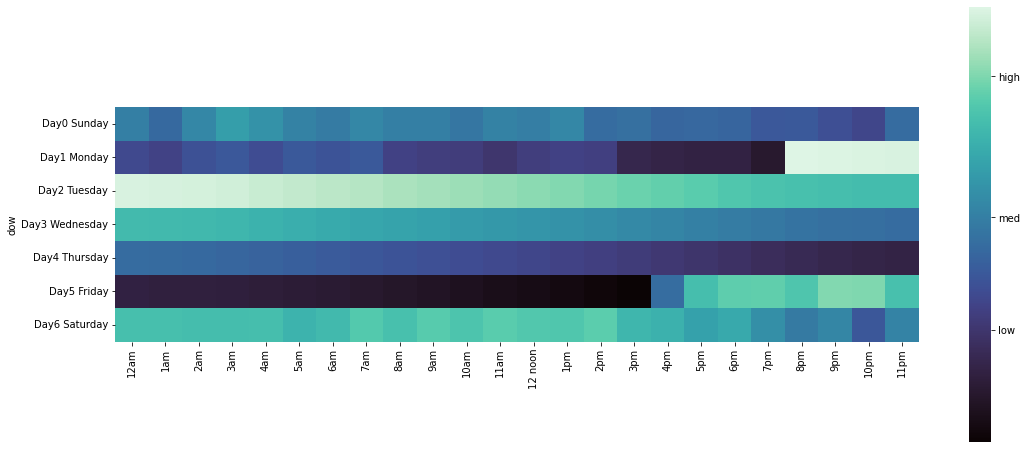

In [334]:
# Heatmap showing Day of the week and time of the day Ride Frequency 
fig,ax = plt.subplots(1,1,figsize=(18,8))


sns.heatmap(dow_hour_rides_dropdow, cmap='mako', square=True, linewidth=0, ax=ax)

colorbar = ax.collections[0].colorbar
M=dow_hour_rides_dropdow.max().max()
colorbar.set_ticks([M/1.73,M/1.38,M/1.1])
colorbar.set_ticklabels(['low','med','high'])

plt.show()

##### There is a high taxi demand after 5pm on Fridays and Saturdays

In [335]:
# getting features for model building - input vs target 

input_cols = ['passenger_count',
       'trip_distance', 'dow', 'hour', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude','dropoff_longitude'
       ]
target_col = 'fare_amount'

In [336]:
cols=['passenger_count','trip_distance', 'dow', 'hour','fare_amount','pickup_latitude', 'pickup_longitude','dropoff_latitude','dropoff_longitude']
data=df[cols]

In [337]:
# One Hot encoding DOW data
one_hot_encoded_data= pd.get_dummies(data, columns= ['dow'])

In [338]:
one_hot_encoded_data.head()

,passenger_count,trip_distance,hour,fare_amount,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6
0,1,3.777487,19,8.0,40.751141,-73.968117,40.732216,-73.980461,0,1,0,0,0,0,0
1,1,5.457855,19,9.5,40.711658,-73.944077,40.719799,-73.982857,0,1,0,0,0,0,0
2,1,19.011739,19,33.5,40.783756,-73.970360,40.709118,-73.870560,0,1,0,0,0,0,0
3,2,2.288864,19,6.0,40.750820,-73.978867,40.740780,-73.989326,0,1,0,0,0,0,0
4,2,12.356255,19,24.5,40.739059,-73.987198,40.672539,-73.962769,0,1,0,0,0,0,0


In [339]:
# Binning the Time of Day into Morning, Evening, Noon and Night

def myfunc(x):
    if x>12 and x<=16 :
        return 'Noon'
    elif x>=8 and x<=12:
        return 'Morning'
    elif  x>16 and x<=20:
        return 'Evening'
    else:
        return 'Night'
#On hot encoding Hour bins
one_hot_encoded_data['hour_bin'] = one_hot_encoded_data.apply(lambda x: myfunc(x.hour), axis=1)

In [340]:
one_hot_encoded_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196611 entries, 0 to 196610
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   passenger_count    196611 non-null  int64  
 1   trip_distance      196611 non-null  float64
 2   hour               196611 non-null  int64  
 3   fare_amount        196611 non-null  float64
 4   pickup_latitude    196611 non-null  float64
 5   pickup_longitude   196611 non-null  float64
 6   dropoff_latitude   196611 non-null  float64
 7   dropoff_longitude  196611 non-null  float64
 8   dow_0              196611 non-null  uint8  
 9   dow_1              196611 non-null  uint8  
 10  dow_2              196611 non-null  uint8  
 11  dow_3              196611 non-null  uint8  
 12  dow_4              196611 non-null  uint8  
 13  dow_5              196611 non-null  uint8  
 14  dow_6              196611 non-null  uint8  
 15  hour_bin           196611 non-null  object 
dtypes:

In [341]:
one_hot_encoded_data= pd.get_dummies(one_hot_encoded_data, columns= ['hour_bin'])

In [342]:
one_hot_encoded_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196611 entries, 0 to 196610
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   passenger_count    196611 non-null  int64  
 1   trip_distance      196611 non-null  float64
 2   hour               196611 non-null  int64  
 3   fare_amount        196611 non-null  float64
 4   pickup_latitude    196611 non-null  float64
 5   pickup_longitude   196611 non-null  float64
 6   dropoff_latitude   196611 non-null  float64
 7   dropoff_longitude  196611 non-null  float64
 8   dow_0              196611 non-null  uint8  
 9   dow_1              196611 non-null  uint8  
 10  dow_2              196611 non-null  uint8  
 11  dow_3              196611 non-null  uint8  
 12  dow_4              196611 non-null  uint8  
 13  dow_5              196611 non-null  uint8  
 14  dow_6              196611 non-null  uint8  
 15  hour_bin_Evening   196611 non-null  uint8  
 16  ho

In [343]:
# dropping Hour column
one_hot_encoded_data=one_hot_encoded_data.drop(columns='hour')

In [344]:
# get top drop locations
drop_rides=sqldf("""select distinct round(dropoff_latitude,2) as drop_lat,round(dropoff_longitude,2) as drop_long,count(trip_id) as rides
    from df group by 1,2 order by 3 desc limit 10""")
drop_rides

,drop_lat,drop_long,rides
0,40.76,-73.98,10760
1,40.76,-73.97,10736
2,40.75,-73.99,10453
3,40.75,-73.98,9856
4,40.76,-73.99,7419
5,40.74,-73.99,7337
6,40.77,-73.96,6172
7,40.74,-73.98,5484
8,40.73,-73.99,5455
9,40.77,-73.98,5349


In [345]:
#get top drop location names from lat ,long 
location=[]
for i in range(len(drop_rides)):
    loc = geolocator.reverse(str(drop_rides['drop_lat'].iloc[i])+","+str(drop_rides['drop_long'].iloc[i]))
    add=loc.raw['address']
    if True:
        try:
            add=add['road']
            location.append(add)
        except KeyError:
            pass


In [346]:
drop_rides['location']=location


In [347]:
drop_rides

,drop_lat,drop_long,rides,location
0,40.76,-73.98,10760,Rockefeller Plaza
1,40.76,-73.97,10736,Lexington Avenue
2,40.75,-73.99,10453,West 33rd Street
3,40.75,-73.98,9856,East 38th Street
4,40.76,-73.99,7419,West 45th Street
5,40.74,-73.99,7337,East 21st Street
6,40.77,-73.96,6172,3rd Avenue
7,40.74,-73.98,5484,East 26th Street
8,40.73,-73.99,5455,East 9th Street
9,40.77,-73.98,5349,Central Park Outer Loop


In [348]:
## top pick locations
pick_rides=sqldf("""select distinct round(pickup_latitude,2) as pick_lat,round(pickup_longitude,2) as pick_long,count(trip_id) as rides
    from df group by 1,2 order by 3 desc limit 10""")
pick_rides

,pick_lat,pick_long,rides
0,40.75,-73.99,12301
1,40.76,-73.97,11979
2,40.76,-73.98,10222
3,40.75,-73.98,10010
4,40.76,-73.99,9166
5,40.74,-73.99,8492
6,40.73,-73.99,7208
7,40.77,-73.98,6612
8,40.77,-73.96,6466
9,40.74,-74.00,6191


#### Top 10 Preferred Ride Destinations

<AxesSubplot:xlabel='location', ylabel='rides'>

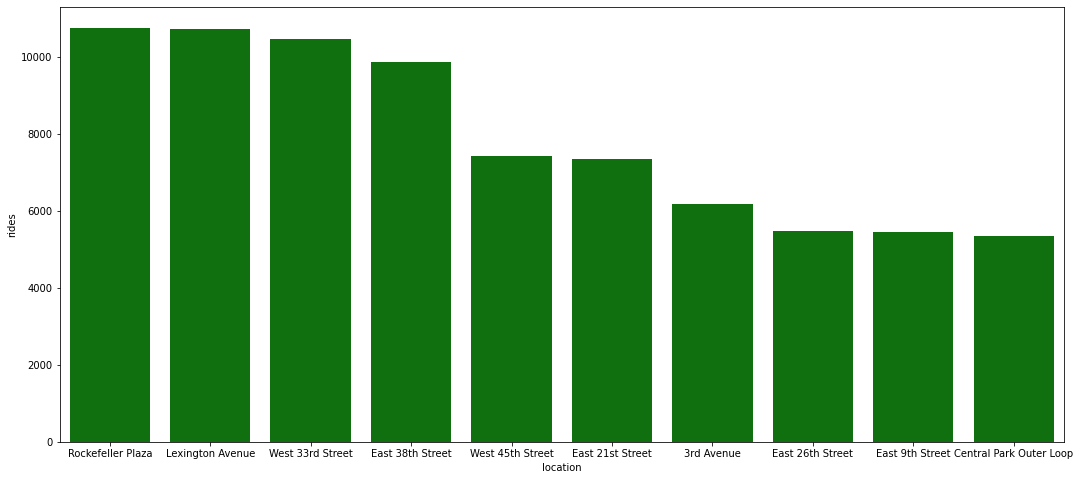

In [349]:

plt.subplots(1,1,figsize=(18,8))
sns.barplot(drop_rides['location'],drop_rides['rides'],color='green')

In [350]:
# get pick location names using lat long
pick_location=[]
for i in range(len(pick_rides)):
    loc = geolocator.reverse(str(pick_rides['pick_lat'].iloc[i])+","+str(pick_rides['pick_long'].iloc[i]))
    add=loc.raw['address']
    if True:
        try:
            add=add['road']
            pick_location.append(add)
        except KeyError:
            pass


In [351]:
pick_rides['pick_location']=pick_location

#### Top 10 Preferred Pickup Locations

<AxesSubplot:xlabel='pick_location', ylabel='rides'>

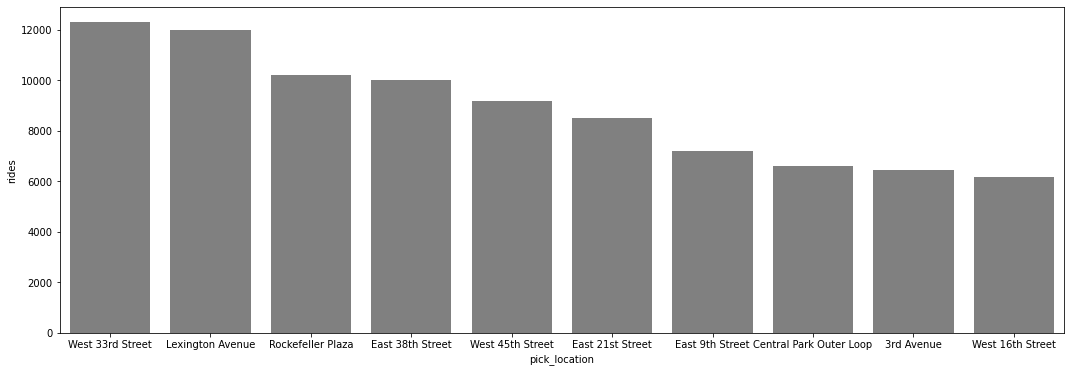

In [352]:
plt.subplots(1,1,figsize=(18,6))
sns.barplot(pick_rides['pick_location'],pick_rides['rides'],color='gray')

#### Relation between No of passengers and Ride Fares

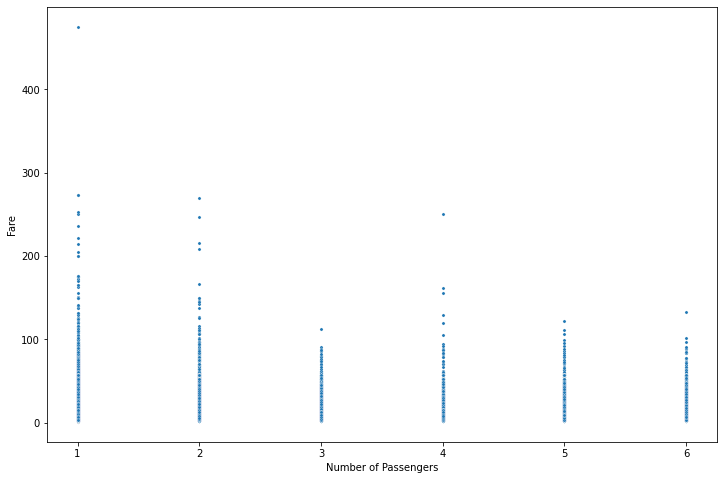

In [353]:


# How does the passenger count affect the fare price?
plt.figure(figsize=(12, 8))
sns.scatterplot(data=train_df, x="passenger_count", y="fare_amount", s=10)
plt.xlabel('Number of Passengers')
plt.ylabel('Fare')
plt.show()

# Modeling and Evaluation

###  Step 1. One Hot Encode the categorical features

### Step 2. Train and Test Split 80:20

### Step 3. Apply Regression Algorithms  - Linear Regression,Lasso, Elastic Net, KNN, CART

### Step 4. Fit models on validation data and evaluate them based on RMSE values 

### Step 5. Check if Ensemble Models perform any better - Gradient Boosting and Random Forests

### Step 6. Select the best performing model and predict the values on the validation set

In [354]:
# Train Test Split

train_df, val_df = train_test_split(one_hot_encoded_data, test_size=0.2, random_state=42)
len(train_df), len(val_df)

(157288, 39323)

In [355]:
train_df.columns

Index(['passenger_count', 'trip_distance', 'fare_amount', 'pickup_latitude',
       'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'dow_0',
       'dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6',
       'hour_bin_Evening', 'hour_bin_Morning', 'hour_bin_Night',
       'hour_bin_Noon'],
      dtype='object')

In [356]:
inp_col=['passenger_count', 'trip_distance', 'dow_0', 'dow_1',
       'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6', 'hour_bin_Evening',
       'hour_bin_Morning', 'hour_bin_Night', 'hour_bin_Noon']
out_col=['fare_amount']
train_inputs = train_df[inp_col]
train_targets = train_df[out_col]
train_inputs.head(3)

,passenger_count,trip_distance,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,hour_bin_Evening,hour_bin_Morning,hour_bin_Night,hour_bin_Noon
124493,1,1.450610,0,0,1,0,0,0,0,0,0,0,1
193316,4,2.636467,0,0,0,0,0,1,0,1,0,0,0
113558,5,34.252201,0,0,0,1,0,0,0,0,0,1,0


In [357]:
train_targets.head()

,fare_amount
124493,16.00
193316,6.50
113558,57.54
138152,5.50
175955,19.00


In [358]:
#validation
val_inputs = val_df[inp_col]
val_targets = val_df[out_col]

In [359]:

#Linear Regression 


linreg_model = LinearRegression()
linreg_model.fit(train_inputs, train_targets)
train_preds = linreg_model.predict(train_inputs)
val_preds = linreg_model.predict(val_inputs)
train_rmse = mean_squared_error(train_targets, train_preds, squared=False)
val_rmse = mean_squared_error(val_targets, val_preds, squared=False)
print('RMSE Score on Validation data',val_rmse)
print('RMSE Score on Validation data',train_rmse)

RMSE Score on Validation data 5.222886038225813
RMSE Score on Validation data 5.382157410454862


In [360]:
# Test options and evaluation metric
num_folds = 10
seed = 7
scoring = 'neg_root_mean_squared_error'

In [361]:
# SCreate different Models and Compare results
models = []
models.append(( 'LR' , LinearRegression()))
models.append(( 'LASSO' , Lasso()))
models.append(( 'EN' , ElasticNet()))
models.append(( 'KNN' , KNeighborsRegressor()))
models.append(( 'CART' , DecisionTreeRegressor()))

In [362]:
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, train_inputs, train_targets, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: -5.363259 (0.457169)
LASSO: -5.425973 (0.445931)
EN: -5.427672 (0.445222)
KNN: -5.511066 (0.427254)
CART: -7.236579 (0.452392)


#### Comparison of Algorithms

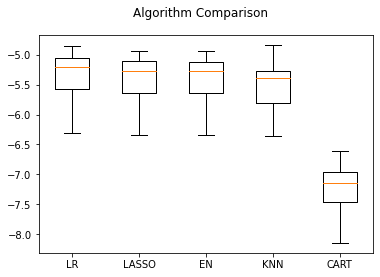

In [363]:
# Compare Algorithms
fig = pyplot.figure()
fig.suptitle( 'Algorithm Comparison' )
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

##### Linear Regression is performing the best 

In [364]:
# ensembles
ensembles = []

ensembles.append(( 'ScaledGBM' , Pipeline([( 'Scaler' , StandardScaler()),( 'GBM' ,
    GradientBoostingRegressor())])))
ensembles.append(( 'ScaledRF' , Pipeline([( 'Scaler' , StandardScaler()),( 'RF' ,
    RandomForestRegressor())])))

results = []
model_list = []
names = []
for name, model in ensembles:
                          kfold = KFold(n_splits=num_folds)
                          cv_results = cross_val_score(model, train_inputs, train_targets, cv=kfold, scoring=scoring)
                          
                          model_list.append(())  
                          results.append(cv_results)
                          names.append(name)
                          msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
                      

#### Comparison of Ensemble Algorithms


##### GBM performed the best

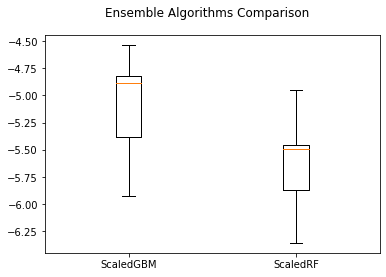

In [365]:
# Compare Algorithms
fig = pyplot.figure()
fig.suptitle( 'Ensemble Algorithms Comparison' )
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [366]:
#validation
val_inputs = val_df[inp_col]
val_targets = val_df[out_col]

In [367]:
# prepare the final model
scaler = StandardScaler().fit(train_inputs)
rescaledX = scaler.transform(train_inputs)
model = GradientBoostingRegressor()
model.fit(rescaledX, train_targets)
rescaledValidationX = scaler.transform(val_inputs)
predictions = model.predict(rescaledValidationX)



In [368]:
predictions

array([13.35347927, 19.12311395,  9.44677111, ...,  7.20129392,
        7.91877807,  7.65745753])

In [369]:
val_targets

,fare_amount
90900,16.5
40661,22.0
124739,8.0
126938,6.5
133675,10.0
...,...
6712,11.5
20512,10.5
75548,7.5
39039,6.0


In [370]:
prediction_results=val_targets
prediction_results['predicted']=predictions

#### Actual vs Predicted Results- GBM

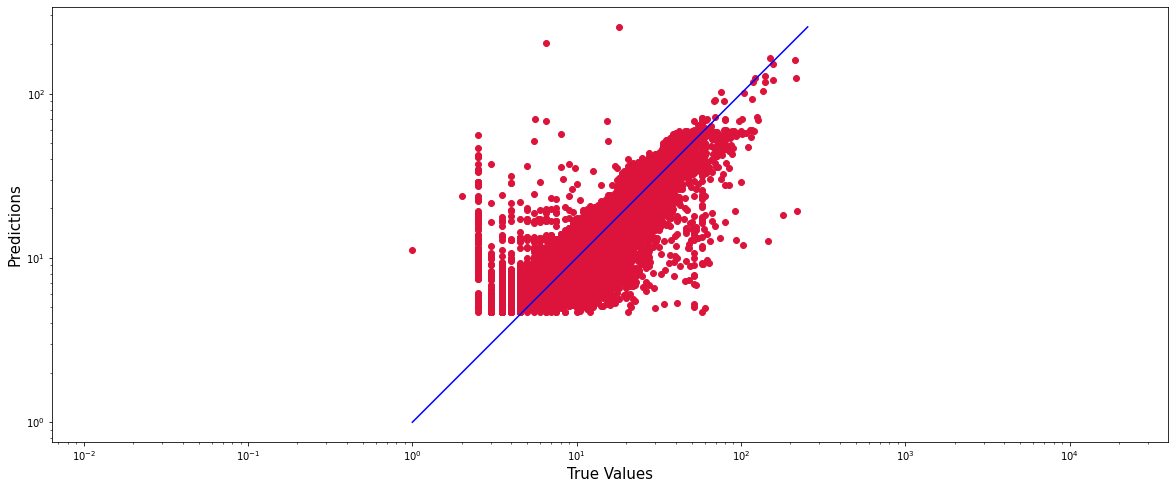

In [371]:
plt.figure(figsize=(20,8))
plt.scatter(prediction_results['fare_amount'], prediction_results['predicted'], c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(prediction_results['predicted']), max(prediction_results['fare_amount']))
p2 = min(min(prediction_results['predicted']), min(prediction_results['fare_amount']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

In [372]:
val_df.head()
val_df.insert(14, "predicted_fair_amt", predictions, True)

#### Predicted Fare Prices across NYC - Interactive Visualization using  Marker on NYC Map

In [373]:

fig3=Figure(width=550,height=350)

m3=folium.Map(location=[40.721319, -73.844311],tiles='cartodbpositron',zoom_start=11)
fig3.add_child(m3)

#Adding markers to the map
i = 0
for index, row in val_df.iterrows():

    if i <50:
        x,y = row["pickup_latitude"], row["pickup_longitude"] 
        fare = np.round(row["predicted_fair_amt"],2)
        folium.Marker(location=[x,y],popup='Default popup Marker1',tooltip="$"+str(fare)).add_to(m3)
        i = i+1
m3

In [374]:


# this function will be used more often to plot data on the NYC map
def plot_on_map(df, BB, nyc_map, s=10, alpha=0.2):
    fig, axs = plt.subplots(1, 2, figsize=(16,10))
    axs[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Pickup locations')
    axs[0].imshow(nyc_map, zorder=0, extent=BB)

    axs[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Dropoff locations')
    axs[1].imshow(nyc_map, zorder=0, extent=BB)

#### Pick up and Drop Locations Hotspots across NYC 

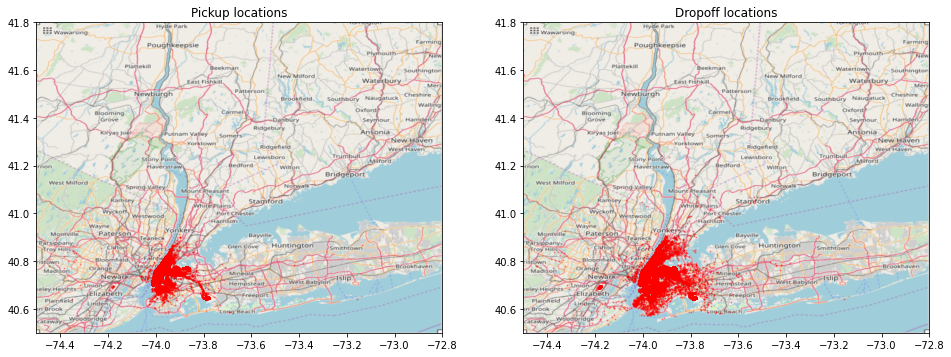

In [375]:
BB = (-74.5, -72.8, 40.5, 41.8)
nyc_map = plt.imread('nyc.png')
plot_on_map(train_df, BB, nyc_map, s=1, alpha=0.3)

### THANK YOU